## Imports

In [14]:
%matplotlib inline
%load_ext autoreload
from sim import *

import matplotlib as mpl
#mpl.use('cairo')

import numpy as np

%autoreload 2
from balance import *

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Analyse results

### Main class


In [23]:
class AnalyseResults:
    DEF_IDX = -1
    def __init__(self, filename):
        self.filename = filename
        """ a list of results
        SimResults = namedtuple("SimulationResults",
                                ("steps", "asymptotic", "coins", "mean_list", "std_list", 
                                "final_distr", "initial_distr", "friendliness", "adjacency"))
        """
        self.results = read_results(filename)

    def sim(self, sim_idx=DEF_IDX):
        return self.results[sim_idx]

    def graph(self, sim_idx=DEF_IDX):
        sim = self.sim(sim_idx)
        return read_graph(sim.adjacency, sim.friendliness)
    
    def draw_graph(self, sim_idx=DEF_IDX):
        draw_graph(self.graph(sim_idx))

    def friendliness(self, sim_idx=DEF_IDX):
        return self.sim(sim_idx).friendliness

    def adjacency(self, sim_idx=DEF_IDX):
        return self.sim(sim_idx).adjacency
    
    def plot_coins(self, sim_idx=DEF_IDX):
        sim = self.sim(sim_idx)
        n = len(sim.initial_distr.T)
        plt.plot(np.cumsum(sim.coins))
        plt.legend(range(n))

    def plot_mean(self, sim_idx=DEF_IDX):
        sim = self.sim(sim_idx)
        n = len(sim.initial_distr.T)
        # alpha is transparency of graph lines
        plt.plot(sim.mean_list, alpha=0.5)
        plt.title(f"Mean/Iter, sim {sim_idx}")
        plt.xlabel("Iteration")
        plt.ylabel("Mean")
        plt.legend(range(n))

    def plot_std(self, sim_idx=DEF_IDX):
        sim = self.sim(sim_idx)
        n = len(sim.initial_distr.T)
        # alpha is transparency of graph lines
        plt.plot(sim.std_list, alpha=0.5)
        plt.title(f"StdDev/Iter, sim {sim_idx}")
        plt.xlabel("Iteration")
        plt.ylabel("Standard Deviation")
        plt.legend(range(n))

    def plot_initial_distr(self, sim_idx=DEF_IDX):
        sim = self.sim(sim_idx)
        n = len(sim.initial_distr.T)
        # alpha is transparency of graph lines
        plt.plot(np.linspace(0, 1, BIAS_SAMPLES), sim.initial_distr.T)
        plt.title(f"Initial distribution, sim {sim_idx}")
        plt.xlabel("$\\theta$")
        plt.ylabel("Probability")
        plt.legend(range(n))

    def plot_final_distr(self, sim_idx=DEF_IDX):
        sim = self.sim(sim_idx)
        n = len(sim.initial_distr.T)
        # alpha is transparency of graph lines
        plt.plot(np.linspace(0, 1, BIAS_SAMPLES), sim.final_distr.T)
        plt.title(f"Final distribution, sim {sim_idx}")
        plt.xlabel("$\\theta$")
        plt.ylabel("Probability")
        plt.legend(range(n))

    def get_col(self, colname):
        return list(map(lambda x: x._asdict()[colname], self.results))

    def steps_asymp(self):
        d = {
            "steps": self.get_col("steps"),
            "asymptotic": self.get_col("asymptotic"),
        }
        return pd.DataFrame(d)

### Actual results

In [24]:
def parse_result(results):
    results_dict = {}
    for i, label in enumerate(["steps", "asymptotic", "coins", "mean_list", "std_list",
                         "final_distr", "initial_distr", "friendliness", "adjacency"]):
        results_dict[label] = results[i]

    for k in ["adjacency", "friendliness", "final_distr", "initial_distr", "mean_list", "std_list"]:
        results_dict[k] = np.asarray(results_dict[k])

    return SimResults(**results_dict)


def read_results(filename):
    with open(filename, 'r') as f:
        top = json.load(f)
        res = top['res']
        args = top['args']
        sim_args = top['sim_params']

        return [parse_result(r) for r in res]
        #results = list(map(parse_result, results))

In [27]:
res = AnalyseResults("output/res-2021_10_21-12_47_14.json")

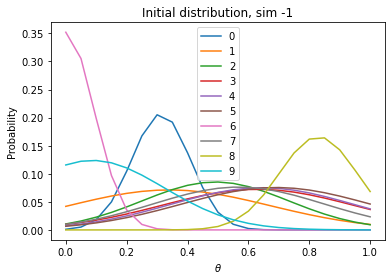

In [28]:
res.plot_initial_distr()

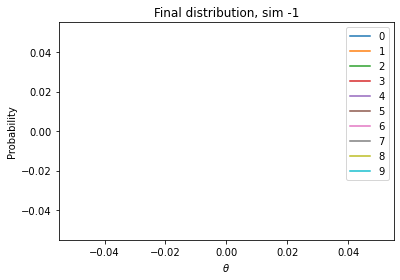

In [31]:
res.plot_final_distr()

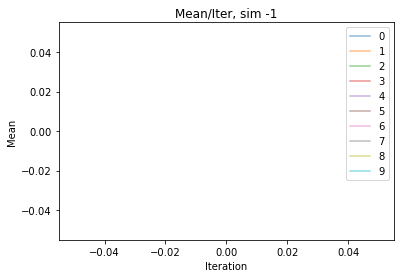

In [32]:
res.plot_mean()

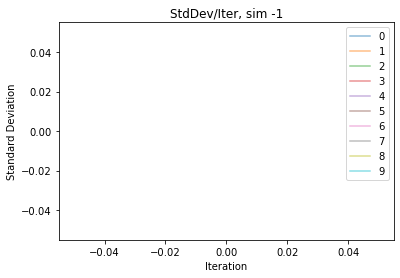

In [33]:
res.plot_std()

### Profiling

In [ ]:
# %%
g = pair_of_allies()
init_simulation(g, prior_mean=np.array((0.25, 0.75)),
                prior_sd=np.array([fwhm_to_sd(0.4)] * 2))

draw_graph(g)
# %%
g = complete_graph_of_enemies(2)

with cProfile.Profile() as pr:
    seed(42)
    res = run_simulation(g,
                         max_steps=2000,
                         prior_mean=np.array((0.25, 0.75)),
                         prior_sd=np.array([fwhm_to_sd(0.4)] * 2),
                         tosses_per_iteration=10
                         )
    steps, asymptotic, coins, mean_std, distr, initial_distr = res
mean_std = np.array(mean_std)
steps, asymptotic

# 0.530 seconds (677 iterations) without graphtool storing priors
# 3.254 seconds (677 iterations) with graphtool

# %%
%%time
g = complete_graph_of_random(3)

init_simulation(g)
res = run_simulation(g, max_steps=1000)

# %%
g.vp.prior_mean.a


# %%
#pr.print_stats()

# %%
last_results_fname = "output/res-{}.json".format(timestamp())
dump_json(res, last_results_fname)

res_read = read_results(last_results_fname)

# works :)


# %%
last_graph_fname = "output/graph-{}.gt".format(timestamp())
g.save(last_graph_fname)

g = gt.load_graph(last_graph_fname)

draw_graph(g)

# %%
%%time
res = do_ensemble(runs=10, gen_graph=lambda: complete_graph_of_enemies(10), sim_params={"max_steps": 1000})


# %%
# %%time
# res = do_ensemble_parallel(runs=10, gen_graph=lambda: complete_graph_of_enemies(10), sim_params={"max_steps": 1000})



# %%
with cProfile.Profile() as pr:
    res = do_ensemble(runs=20, gen_graph=lambda: complete_graph_of_random(15), sim_params={"max_steps": 10000})

# %%
pr.print_stats()

# %%
%%time
res = do_ensemble(runs=20, gen_graph=lambda: complete_graph_of_friends(10), sim_params={"max_steps": 1000})

# %%


## Cluster stuff

In [ ]:
def draw_cluster_graph_nick(g):
    edge_color_map = {-1.0: (1, 0, 0, 1),  # red
                        1.0: (0, 1, 0, 1),  # green
                        0.0: (0, 0, 0, 0)}  # black

    edge_color = g.new_ep('vector<double>')
    for f, e in zip(g.ep.friendliness, g.edges()):
        edge_color[e] = edge_color_map[f]

    cluster_ids = g.new_vp('int')
    cluster_ids.a = get_clusters_nick(friendliness_mat(g))


    gt.graph_draw(g,vertex_text=cluster_ids,
                    edge_color=edge_color,
                    output_size=(150, 150))

In [59]:
def get_clusters_nick(adj):
    adj2 = adj.copy()
    np.fill_diagonal(adj2, 1)  # diagonal entries must be >0 for the below trick to work
    group_id = np.full(adj.shape[0], adj.shape[0], dtype=np.int32)
    
    # group friends into the same group
    checked_nodes = set()
    for i in range(adj.shape[0]):
        if i in checked_nodes:
            continue
        group_id[i] = i
        queued_friends = {i}  # this is a set
        while queued_friends:
            current_node = queued_friends.pop()
            
            friends = np.nonzero(adj2[current_node] > 0)[0]
            new_friends = [j for j in friends if not j in checked_nodes]
            for friend in new_friends:
                group_id[friend] = i
            queued_friends.update(new_friends)
            checked_nodes.add(current_node)
        
    # now check for enemies. if two nodes in the same group are enemies, then the network is unbalanced
    # for i in range(adj.shape[0]-1):
    #     enemies = adj2[i] < 0
    #     has_contradiction = np.any(group_id[i] == group_id[enemies])
    #     if has_contradiction:
    #         return 0
    
    enemies = adj2 < 0
    has_contradiction = np.any((group_id.reshape(-1,1) == group_id)[enemies])
    if has_contradiction:
        return 0
        
    # now check if we can minimise the number of unique group id
    no_change = False
    while not no_change:
        no_change = True
        unique_id = np.unique(group_id)
        combo = []
        for i in range(unique_id.shape[0]):
            for j in range(i+1, unique_id.shape[0]):
                combo.append((unique_id[i], unique_id[j]))
        # combo = itertools.combinations(unique_id, 2)
        for u, v in combo:
            nodes1 = np.nonzero(group_id == u)[0]
            nodes2 = np.nonzero(group_id == v)[0]
            can_merge = True
            for i in nodes1:
                for j in nodes2:
                    if adj2[i,j] < 0:
                        can_merge = False
                        break
                if not can_merge:
                    break
            
            if can_merge:
                no_change = False
                group_id[nodes2] = u
                break
    
    return group_id

In [69]:
def get_clusters(g):
    cluster_ids = g.new_vertex_property('int')
    cluster_ids.a = np.full(g.num_vertices(), -1)

    for v in g.iter_vertices():
        pass

    return cluster_ids


In [72]:
draw_cluster_graph(g)

KeyError: ('v', 'cluster_id')

Balance.WEAKLY


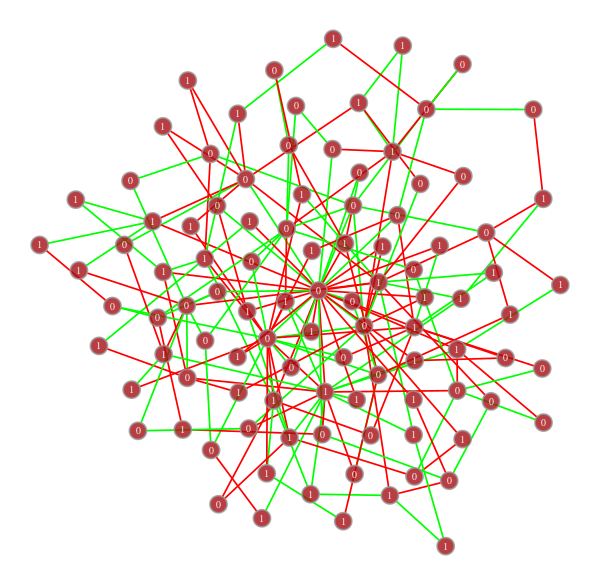

In [93]:
g = gen_balanced_type(Balance.STRONGLY, n=100, m=2)

print(test_graph_balance(g))
draw_cluster_graph(g)

In [77]:
draw_cluster_graph_nick(g)

NameError: name 'draw_cluster_graph_nick' is not defined

In [54]:
-(adjacency_mat(g) - 1)

array([[ 1., -0., -0.,  1.,  1., -0., -0., -0., -0., -0.],
       [-0.,  1., -0., -0.,  1.,  1.,  1.,  1.,  1.,  1.],
       [-0., -0.,  1., -0., -0.,  1., -0.,  1.,  1.,  1.],
       [ 1., -0., -0.,  1., -0.,  1.,  1.,  1.,  1.,  1.],
       [ 1.,  1., -0., -0.,  1., -0.,  1.,  1.,  1.,  1.],
       [-0.,  1.,  1.,  1., -0.,  1.,  1.,  1., -0.,  1.],
       [-0.,  1., -0.,  1.,  1.,  1.,  1., -0.,  1.,  1.],
       [-0.,  1.,  1.,  1.,  1.,  1., -0.,  1.,  1.,  1.],
       [-0.,  1.,  1.,  1.,  1., -0.,  1.,  1.,  1., -0.],
       [-0.,  1.,  1.,  1.,  1.,  1.,  1.,  1., -0.,  1.]])

In [52]:
friendliness_mat(g)

array([[ 0., -1., -1.,  0.,  0.,  1.,  1.,  1., -1.,  1.],
       [-1.,  0.,  1., -1.,  0.,  0.,  0.,  0.,  0.,  0.],
       [-1.,  1.,  0., -1.,  1.,  0., -1.,  0.,  0.,  0.],
       [ 0., -1., -1.,  0., -1.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  1., -1.,  0., -1.,  0.,  0.,  0.,  0.],
       [ 1.,  0.,  0.,  0., -1.,  0.,  0.,  0., -1.,  0.],
       [ 1.,  0., -1.,  0.,  0.,  0.,  0.,  1.,  0.,  0.],
       [ 1.,  0.,  0.,  0.,  0.,  0.,  1.,  0.,  0.,  0.],
       [-1.,  0.,  0.,  0.,  0., -1.,  0.,  0.,  0., -1.],
       [ 1.,  0.,  0.,  0.,  0.,  0.,  0.,  0., -1.,  0.]])